# Parameter Estimation I

Now that we have a decent understanding of the general form of rate expressions for surface reactions that follow, we will consider some strategies for proposing a mechanism from observed trends in reaction rate. We will also work through developing rate laws from proposed mechanisms as well as parameter estimation via nonlinear regression.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
from math import ceil, floor
import pandas as pd

## Nonlinear Least Squares Recap:

No matter what problem we are trying to solve, the basic idea and methodology behind nonlinear least squares is always the same:

1. We propose a model that includes variable parameters (e.g., a rate constant or reaction order).
2. We use that model to calculate the value of a measurable/observable quantity at each experimental condition (e.g., we use it to calculate a concentration at a specific time or a rate at a specific temperature).
3. We calculate the square error between each measurement and the value predicted by the model at that same condition.
4. We calculate the sum of square errors for the entire data set.
5. We use an iterative solver to vary the parameter values until the sum of square errors is at a minimum.

```{tip}
As we work through nonlinear least squares, keep these general concepts in mind. It will help you to develop a general idea of how nonlinear least squares works, which is better than trying to memorize formulas or functions used in nonlinear least squares.
```

## Example Problem 01

The following data analysis is representative of the type of work we do in our research group.  We will start with an overall, macroscopic reaction. We would like to determine the underlying mechanism of this reaction, and we would like to also develop a rate expression that we can use to design a reactor for this process.

$$A + B\longrightarrow C$$

We go into the laboratory, and we collect a lot of kinetic data.  Specifically, we estimate rates of reaction by measuring the effluent flowrate of the reaction product $C$ in a differential plug flow reactor that has a volume of 1.0L. We measured rates of reaction at various concentrations of $A$, concentrations of $B$, and reaction temperature. Eventually, we'll consider the full data set, but for right now, let's just look at data collected at $T = 573 \ \mathrm{K}$ for various concentrations of $A$ and $B$. The data is saved in the DATA1.csv file included with this worksheet.

First, we will load the rate data obtained at 573K. In this data set, concentrations of $A$ (Column 1) and $B$ (Column 2) are in moles per liter, temperature (Column 3) is in Kelvin, and the rate of reaction (Column 4) is in moles per liter per minute.

1. Determine the reaction orders in $A$ and $B$
2. Propose a rate law that is consistent with the observed behavior.


In [3]:
#################################################################################################
# Load experimental measurements for first problem into a data frame                            #
#################################################################################################

DATA1df = pd.read_csv("DATA1.csv", names = ["CA (mol/L)", "CB (mol/L)", "T (K)", "rate (mol/L/s)"])

#################################################################################################
# Convert data frame to numpy array --> easier for elementwise math                             #
#################################################################################################

DATA1   = pd.DataFrame.to_numpy(DATA1df)
DATA1df

,CA (mol/L),CB (mol/L),T (K),rate (mol/L/s)
0,0.0001,0.0100,573.0,0.000234
1,0.0002,0.0100,573.0,0.000496
2,0.0005,0.0100,573.0,0.001220
3,0.0010,0.0100,573.0,0.002080
4,0.0020,0.0100,573.0,0.004440
5,0.0050,0.0100,573.0,0.008700
6,0.0100,0.0100,573.0,0.011800
7,0.0200,0.0100,573.0,0.014100
8,0.0500,0.0100,573.0,0.013600
9,0.1000,0.0100,573.0,0.010400


Let's divide this data set up into two experiments: The first one (indices 0 to 16) will comprise data measured at a fixed value of $C_B = 0.01 \ \mathrm{M}$ and the second one will comprise data measured at a fixed value of $C_A = 0.01 \ \mathrm{M}$ (indices 17 to 33).

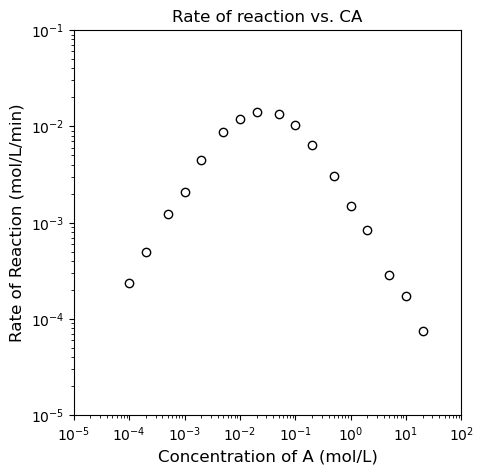

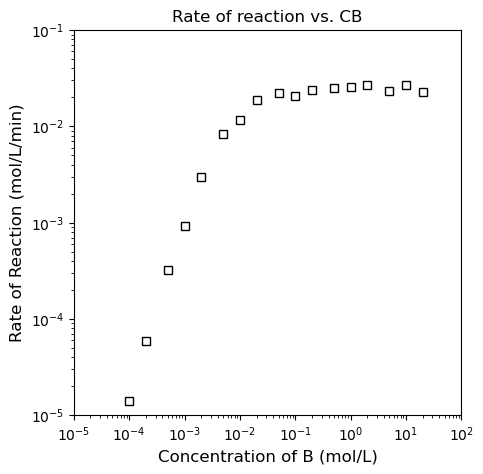

In [4]:
#################################################################################################
# Store CA, CB, and rate data for each experiment in separate numpy arrays                      #
#################################################################################################

EXP1  = DATA1[0:17, :]
EXP2  = DATA1[17:,:]

#################################################################################################
# First experiment (fix CB, vary CA)                                                            #
#################################################################################################

CA1  = EXP1[:,0]
CB1  = EXP1[:,1]
T1   = EXP1[:,2]
r1   = EXP1[:,3]

#################################################################################################
# Second experiment (fix CA, vary CB)                                                           #
#################################################################################################

CA2  = EXP2[:,0]
CB2  = EXP2[:,1]
T2   = EXP2[:,2]
r2   = EXP2[:,3]

#################################################################################################
# Graph the results of the first experiment (r vs. CA)                                          #
#################################################################################################

plt.figure(1, figsize = (5, 5))
plt.loglog(CA1, r1, marker = 'o', markerfacecolor = 'none', markeredgecolor = 'black', linestyle = 'none')
plt.title('Rate of reaction vs. CA')
plt.xlim(1e-5, 1e2)
plt.ylim(1e-5, 1e-1)
plt.xlabel('Concentration of A (mol/L)', fontsize = 12)
plt.ylabel('Rate of Reaction (mol/L/min)', fontsize = 12)
plt.show()

#################################################################################################
# Graph the results of the second experiment (r vs. CB)                                         #
#################################################################################################

plt.figure(2, figsize = (5, 5))
plt.loglog(CB2, r2, marker = 's', markerfacecolor = 'none', markeredgecolor = 'black', linestyle = 'none')
plt.title('Rate of reaction vs. CB')
plt.xlim(1e-5, 1e2)
plt.ylim(1e-5, 1e-1)
plt.xlabel('Concentration of B (mol/L)', fontsize = 12)
plt.ylabel('Rate of Reaction (mol/L/min)', fontsize = 12)
plt.show()

From the observed trends, we can conclude that there is a change in reaction order with respect to both $C_A$ and $C_B$ as we transition from low concentration regimes to high concentration regimes. More specifically, we can see that the rate of reaction is initially positive order in $A$ $(C_A < 10^{-2} \ \mathrm{M})$, it then transitions to zero order in $A$ $(10^{-2} < C_A < 10^{-1} \ \mathrm{M})$, and eventually it becomes negative order in $A$ $(C_A > 10^{-1} \ \mathrm{M})$.  We can determine the actual values of positive and negative reaction orders by recalling the general form of power law kinetics:

$r = k {C_A}^\alpha {C_B}^\beta$

This can be linearized using a logarithmic transformation:

$\ln(r) = \ln(k) + \alpha \ln({C_A}) + \beta \ln({C_B})$

One can find the reaction order in $A$ by recognizing that, in the first experimental data set, $C_B$ is constant, so we can lump terms that vary with $C_B$ into a coefficient, $C$, and an apparent rate constant, $k^\prime$.

$\ln(r) = C\ln(k^\prime) + \alpha \ln({C_A})$

Similarly, for the second experimental data set, we recognize that $C_A$ is a constant, so terms that depend on $C_A$ can be lumped into a coefficient, $D$, and a second apparent rate constant, $k^{\prime\prime}$. 

$\ln(r) = D\ln(k^{\prime\prime}) + \alpha \ln({C_B})$

For this analysis, we do not care much about the values of the lumped constants $C$, $D$, $k^\prime$, and $k^{\prime\prime}$. For now, we're only interested in the reaction orders at various concentrations. This will help us to build insight into the limiting behavior of reaction rates as we vary reactant concentrations.

In [5]:
################################################################################################
# Fit a straight line (y = mx + b) to low concentration data                                   #
################################################################################################

coeffs1low  = np.polyfit(np.log(CA1[0:3]), np.log(r1[0:3]), 1)
coeffs2low  = np.polyfit(np.log(CB2[0:3]), np.log(r2[0:3]), 1)

################################################################################################
# Fit a straight line (y = mx + b) to high concentration data                                  #
################################################################################################

coeffs1high = np.polyfit(np.log(CA1[-4:]), np.log(r1[-4:]), 1)
coeffs2high = np.polyfit(np.log(CB2[-4:]), np.log(r2[-4:]), 1)

################################################################################################
# Extract values for α and β at both low and high concentrations                               #
################################################################################################

α_low  = coeffs1low[0]
α_high = coeffs1high[0]
β_low  = coeffs2low[0]
β_high = coeffs2high[0]

################################################################################################
# Print reaction orders at low and high concentrations                                         #
################################################################################################

print(f'At low CA, α = {α_low:3.1f}. At high CA, α = {α_high:3.1f}.')
print(f'At low CB, β = {β_low:3.1f}. At high CB, β = {abs(β_high):4.1f}.')

At low CA, α = 1.0. At high CA, α = -1.0.
At low CB, β = 2.0. At high CB, β =  0.0.


## Example Problem 02

Based on the above observations, we can propose the following rate law:

$$r = \frac{kC_A{C_B}^2}{(1 + K_AC_A + K_BC_B)^2}$$

We can justify this model by noting that it will predict the correct limiting behavior as $C_A$ and $C_B$ vary between low and high concentrations. We cannot say for sure that this is the correct rate law, but we can say that it adequately predicts observed trends. Now that we've established a plausible rate law, we can try to regress our parameters using least squares.  Our steps, as always:

1. We propose a model
2. We use that model to calculate a prediction at every experimental condition
3. We calculate the error (residual, square error) between prediction and measurement
4. We make a good guess as to the initial values of our parameters
5. We use an iterative algorithm to minimize the sum of square error by varying those parameters.

Let's start just by building the model and using a set of parameter values that we guess and see how it compares to our experimental measurements.  Once we do that, we can use that model to construct an objective function, and then we'll estimate all three parameters that we need to solve this rate law.

To help stabilize our parameter estimation, I will state in that we know the Arrhenius pre-exponential factor:

$$A = 1\times 10^{18} \ \textrm{L}^{2} \ \textrm{mol}^{-2} \ \textrm{min}^{-1}$$

We will use this pre-factor to calculate a rate constant:

$$k = Ae^{\frac{-EA}{RT}}$$


In [10]:
########################################################################################################
# Build a temporary or helper function; it will calculate many things of interest to us, including SSE #
########################################################################################################

def tempfun4(par):
    
    EA, KA, KB = par
    A          = 1e18 #L^2/mol^2/min
    R          = 8.314 #J/mol/K
    
    CA    = DATA1[:,0]
    CB    = DATA1[:,1]
    T     = DATA1[:,2]
    rexp  = DATA1[:,3]
    
    k     = A*np.exp(-EA/R/T)
    rmod  = k*CA*CB**2/(1 + KA*CA + KB*CB)**2
    resid = (rexp - rmod)/rexp
    SSE   = sum(resid**2)
    return [SSE, rmod, rexp, resid]

########################################################################################################
# Sometimes it is helpful to run the function to make sure it is returning correct outputs             #
########################################################################################################

par0 = [100000, 1000, 1000]
# tempfun4(par0)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.14682649896310213
        x: [ 1.080e+05  2.958e+03  7.540e+03]
      nit: 49
      jac: [-2.738e-07 -7.004e-07 -2.034e-06]
 hess_inv: [[ 1.550e+05 -5.582e+04  1.397e+05]
            [-5.582e+04  1.058e+05 -6.785e+04]
            [ 1.397e+05 -6.785e+04  1.294e+05]]
     nfev: 256
     njev: 64
EA = 108049 J/mol, KA =  2958 L/mol, KB =  7540 L/mol, SSE = 0.147


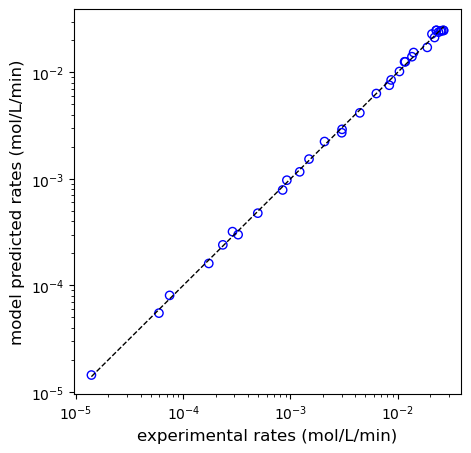

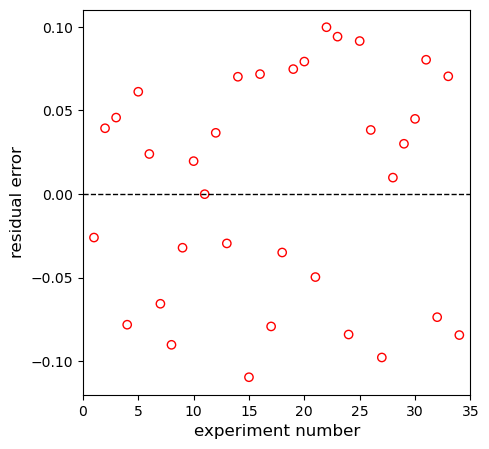

In [11]:
########################################################################################################
# We can make an objective function to optimize by returning only the first output from tempfun4(par)  #
# We define a set of initial guesses at the three parameters and then use opt.minimize and print ans   #
########################################################################################################

obj4 = lambda par: tempfun4(par)[0]
par0 = [100000, 1000, 1000] 
ans4 = opt.minimize(obj4, par0)
print(ans4)

#########################################################################################################
# For a little more sophisticated analysis, extract relevant quantities from ans4 and tempfun outputs   #
# Note that tempfun4 is evaluated here at the optimum parameter set from opt.minimize()                 #
#########################################################################################################

EA, KA, KB = ans4.x
SSE, rmod, rexp, resid = tempfun4([EA, KA, KB])
print(f'EA = {EA:5.0f} J/mol, KA = {KA:5.0f} L/mol, KB = {KB:5.0f} L/mol, SSE = {SSE:3.3f}')

##########################################################################################################
# Create figures for a visual illustration of quality of fit; these are a parity plot and residual plot  #
##########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(rexp, rmod, marker = 'o', color = 'none', edgecolor = 'blue')
plt.plot([min(rexp), max(rexp)], [min(rexp), max(rexp)], color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('experimental rates (mol/L/min)', fontsize = 12)
plt.ylabel('model predicted rates (mol/L/min)', fontsize = 12)
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(np.linspace(1, len(rexp), len(rexp)), resid, marker = 'o', color = 'none', edgecolor = 'red')
plt.hlines(0, 0, len(rexp)+1, linestyle = 'dashed', color = 'black', linewidth = 1)
plt.xlim(0, len(rexp)+1)
plt.xlabel('experiment number', fontsize = 12)
plt.ylabel('residual error', fontsize = 12)
plt.show()

## Example Problem 03

Now let's see if we can do this for the whole data set, where temperatures are actually changing.  We know that equilibrium constants change with temperature, so we cannot use a single, fixed value for KA and KB anymore.  Instead, we have to use a model to describe how they change with temperature.  Here, I'll use a van't Hoff equation, where their values are referenced to the equilibrium constant calculated at the mean reaction temperature.

$$K_i = K_{im}e^{\frac{-\Delta H_i}{RT}\left(\frac{1}{T}-\frac{1}{T_m}\right)}$$

In [18]:
#################################################################################################
# Load experimental measurements for first problem into a data frame                            #
#################################################################################################

DATA2df = pd.read_csv("DATA2.csv", names = ["CA (mol/L)", "CB (mol/L)", "T (K)", "rate (mol/L/s)"])

#################################################################################################
# Convert data frame to numpy array --> easier for elementwise math                             #
#################################################################################################

DATA2   = pd.DataFrame.to_numpy(DATA2df)
DATA2df

,CA (mol/L),CB (mol/L),T (K),rate (mol/L/s)
0,0.0001,0.01,573.0,0.000234
1,0.0002,0.01,573.0,0.000496
2,0.0005,0.01,573.0,0.001220
3,0.0010,0.01,573.0,0.002080
4,0.0020,0.01,573.0,0.004440
...,...,...,...,...
131,0.0100,1.00,723.0,12800.000000
132,0.0100,2.00,723.0,12800.000000
133,0.0100,5.00,723.0,12600.000000
134,0.0100,10.00,723.0,13200.000000


In [19]:
########################################################################################################
# Build a 2nd temporary function; it will calculate many things of interest to us, including SSE       #
# This is pretty much the same function as tempfun5, it just uses DATA2 instead of DATA1               #
# It also has more parameters; the temperature variation allows us to regress heats of reaction        #
########################################################################################################

def tempfun5(par):

    EA, KA0, DHA, KB0, DHB  = par
    
    CA   = DATA2[:,0]
    CB   = DATA2[:,1]
    T    = DATA2[:,2]
    rexp = DATA2[:,3]
    
    A    = 1e18 #L^22/mol^2/min
    R    = 8.314
    Tm   = np.mean(T)
    
    k     = A*np.exp(-EA/R/T)
    KA    = KA0*np.exp(-DHA/R*(1/T - 1/Tm))
    KB    = KB0*np.exp(-DHB/R*(1/T - 1/Tm))
    rmod  = k*CA*CB**2/(1 + KA*CA + KB*CB)**2
    resid = (rmod - rexp)/rexp
    SSE   = sum(resid**2)
    return [SSE, rmod, rexp, resid]

########################################################################################################
# Sometimes it is helpful to run the function to make sure it is returning correct outputs             #
########################################################################################################

# par0 = [100000, 1000, -100000, 1000, -100000]
# tempfun2(par0, DATA2)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.5371984111963196
        x: [ 9.598e+04  7.331e+02 -1.097e+05  2.192e+03 -1.032e+05]
      nit: 120
      jac: [ 1.639e-07  4.672e-06  1.192e-07 -1.438e-06 -1.490e-07]
 hess_inv: [[ 6.645e+06 -4.817e+05 ... -1.371e+06  2.464e+06]
            [-4.817e+05  3.654e+04 ...  9.876e+04 -1.691e+05]
            ...
            [-1.371e+06  9.876e+04 ...  2.905e+05 -4.905e+05]
            [ 2.464e+06 -1.691e+05 ... -4.905e+05  7.469e+06]]
     nfev: 840
     njev: 140
EA = 95984 J/mol, KA0 =   733 L/mol, DHA = -109738 J/mol, KB0 =  2192 L/mol, DHB = -103183 J/mol, SSE = 0.537


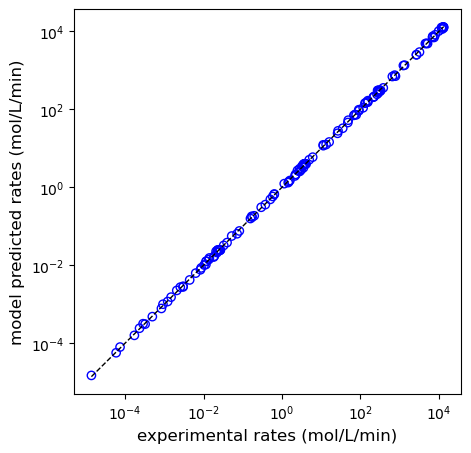

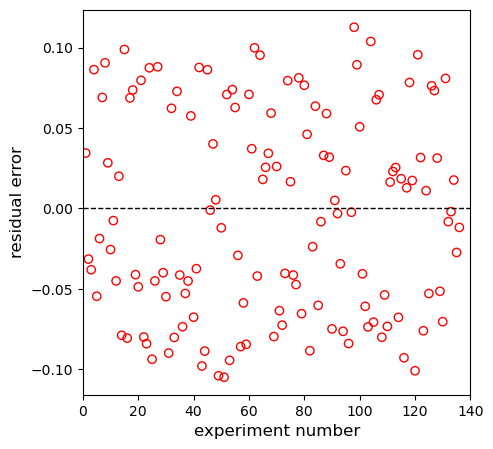

In [20]:
########################################################################################################
# We can make an objective function to optimize by returning only the first output from tempfun4(par)  #
# We define a set of initial guesses at the three parameters and then use opt.minimize and print ans   #
########################################################################################################

obj5 = lambda par: tempfun5(par)[0]
par0 = [100000, 1000, -100000, 1000, -100000]
ans5 = opt.minimize(obj5, par0)
print(ans5)

#########################################################################################################
# For a little more sophisticated analysis, extract relevant quantities from ans4 and tempfun outputs   #
# Note that tempfun5 is evaluated here at the optimum parameter set from opt.minimize()                 #
#########################################################################################################

EA, KA0, DHA, KB0, DHB = ans5.x
SSE, rmod, rexp, resid = tempfun5([EA, KA0, DHA, KB0, DHB])
print(f'EA = {EA:5.0f} J/mol, KA0 = {KA0:5.0f} L/mol, DHA = {DHA:5.0f} J/mol, KB0 = {KB0:5.0f} L/mol, DHB = {DHB:5.0f} J/mol, SSE = {SSE:5.3f}')

##########################################################################################################
# Create figures for a visual illustration of quality of fit; these are a parity plot and residual plot  #
##########################################################################################################

plt.figure(figsize = (5, 5))
plt.scatter(rexp, rmod, marker = 'o', color = 'none', edgecolor = 'blue')
plt.plot([min(rexp), max(rexp)], [min(rexp), max(rexp)], color = 'black', linestyle = 'dashed', linewidth = 1)
plt.xlabel('experimental rates (mol/L/min)', fontsize = 12)
plt.ylabel('model predicted rates (mol/L/min)', fontsize = 12)
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.figure(figsize = (5, 5))
plt.scatter(np.linspace(1, len(rexp), len(rexp)), resid, marker = 'o', color = 'none', edgecolor = 'red')
plt.hlines(0, 0, 140, linestyle = 'dashed', color = 'black', linewidth = 1)
plt.xlim(0, 140)
plt.xlabel('experiment number', fontsize = 12)
plt.ylabel('residual error', fontsize = 12)
plt.show()